In [1]:
import glob
import math
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import openslide
import os
import PIL
from PIL import Image, ImageDraw, ImageFont
import re
import sys
import numpy as np
import scipy.ndimage.morphology as sc_morph
import skimage.color as sk_color
import skimage.exposure as sk_exposure
import skimage.feature as sk_feature
import skimage.filters as sk_filters
import skimage.future as sk_future
import skimage.morphology as sk_morphology
import skimage.segmentation as sk_segmentation
from enum import Enum
import colorsys
import skimage.io
Image.MAX_IMAGE_PIXELS = None

In [2]:
import pandas as pd

In [57]:
pd.set_option('display.max_rows', None)

In [8]:
pd.set_option('display.max_columns', None)

In [67]:
df = pd.read_csv('clinical.tsv',delimiter='\t')

In [31]:
df

,case_id,case_submitter_id,project_id,age_at_index,age_is_obfuscated,cause_of_death,cause_of_death_source,country_of_residence_at_enrollment,days_to_birth,days_to_death,ethnicity,gender,occupation_duration_years,premature_at_birth,race,vital_status,weeks_gestation_at_birth,year_of_birth,year_of_death,age_at_diagnosis,ajcc_clinical_m,ajcc_clinical_n,ajcc_clinical_stage,ajcc_clinical_t,ajcc_pathologic_m,ajcc_pathologic_n,ajcc_pathologic_stage,ajcc_pathologic_t,ajcc_staging_system_edition,anaplasia_present,anaplasia_present_type,ann_arbor_b_symptoms,ann_arbor_clinical_stage,ann_arbor_extranodal_involvement,ann_arbor_pathologic_stage,best_overall_response,breslow_thickness,burkitt_lymphoma_clinical_variant,child_pugh_classification,circumferential_resection_margin,classification_of_tumor,cog_liver_stage,cog_neuroblastoma_risk_group,cog_renal_stage,cog_rhabdomyosarcoma_risk_group,days_to_best_overall_response,days_to_diagnosis,days_to_last_follow_up,days_to_last_known_disease_status,days_to_recurrence,eln_risk_classification,enneking_msts_grade,enneking_msts_metastasis,enneking_msts_stage,enneking_msts_tumor_site,esophageal_columnar_dysplasia_degree,esophageal_columnar_metaplasia_present,figo_stage,figo_staging_edition_year,first_symptom_prior_to_diagnosis,gastric_esophageal_junction_involvement,gleason_grade_group,gleason_grade_tertiary,gleason_patterns_percent,goblet_cells_columnar_mucosa_present,greatest_tumor_dimension,gross_tumor_weight,icd_10_code,igcccg_stage,inpc_grade,inpc_histologic_group,inrg_stage,inss_stage,international_prognostic_index,irs_group,irs_stage,ishak_fibrosis_score,iss_stage,largest_extrapelvic_peritoneal_focus,last_known_disease_status,laterality,lymph_node_involved_site,lymph_nodes_positive,lymph_nodes_tested,lymphatic_invasion_present,margin_distance,margins_involved_site,masaoka_stage,medulloblastoma_molecular_classification,metastasis_at_diagnosis,metastasis_at_diagnosis_site,method_of_diagnosis,micropapillary_features,mitosis_karyorrhexis_index,mitotic_count,morphology,non_nodal_regional_disease,non_nodal_tumor_deposits,ovarian_specimen_status,ovarian_surface_involvement,papillary_renal_cell_type,percent_tumor_invasion,perineural_invasion_present,peripancreatic_lymph_nodes_positive,peripancreatic_lymph_nodes_tested,peritoneal_fluid_cytological_status,pregnant_at_diagnosis,primary_diagnosis,primary_gleason_grade,prior_malignancy,prior_treatment,progression_or_recurrence,residual_disease,satellite_nodule_present,secondary_gleason_grade,site_of_resection_or_biopsy,sites_of_involvement,supratentorial_localization,synchronous_malignancy,tissue_or_organ_of_origin,transglottic_extension,tumor_confined_to_organ_of_origin,tumor_depth,tumor_focality,tumor_grade,tumor_largest_dimension_diameter,tumor_regression_grade,tumor_stage,vascular_invasion_present,vascular_invasion_type,weiss_assessment_score,who_cns_grade,who_nte_grade,wilms_tumor_histologic_subtype,year_of_diagnosis,chemo_concurrent_to_radiation,days_to_treatment_end,days_to_treatment_start,initial_disease_status,number_of_cycles,reason_treatment_ended,regimen_or_line_of_therapy,therapeutic_agents,treatment_anatomic_site,treatment_arm,treatment_dose,treatment_dose_units,treatment_effect,treatment_effect_indicator,treatment_frequency,treatment_intent_type,treatment_or_therapy,treatment_outcome,treatment_type
0,611600a6-43ec-4029-9682-cd6d6a3312ec,TCGA-13-1483,TCGA-OV,61,'--,'--,'--,'--,-22342,895,not hispanic or latino,female,'--,'--,white,Dead,'--,1939,2002,22342,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,not reported,'--,'--,'--,'--,'--,0,895,'--,'--,'--,'--,'--,'--,'--,'--,'--,Stage IIIC,'--,'--,'--,'--,'--,'--,'--,'--,'--,C56.9,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,not reported,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,8441/3,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,'--,"Serous cystadenocarcinoma, NOS",'--,not reported,No,not reported,'--,'--,'--,Ovary,'--,'--,Not Reported,Ovary,'--,'--,'--

In [7]:
df['label'] = df['primary_diagnosis']

0       Serous cystadenocarcinoma, NOS
1       Serous cystadenocarcinoma, NOS
2       Serous cystadenocarcinoma, NOS
3       Serous cystadenocarcinoma, NOS
4       Serous cystadenocarcinoma, NOS
                     ...              
1169    Serous cystadenocarcinoma, NOS
1170    Serous cystadenocarcinoma, NOS
1171    Serous cystadenocarcinoma, NOS
1172    Serous cystadenocarcinoma, NOS
1173    Serous cystadenocarcinoma, NOS
Name: primary_diagnosis, Length: 1174, dtype: object

In [69]:
df['primary_diagnosis'].value_counts()

Serous cystadenocarcinoma, NOS         1160
Papillary serous cystadenocarcinoma       8
Serous surface papillary carcinoma        4
Cystadenocarcinoma, NOS                   2
Name: primary_diagnosis, dtype: int64

In [33]:
import json

In [38]:
with open('clinical.cases_selection.2020-09-15.json') as f:
    data = json.loads(f.read())

In [40]:
def flatten_json(y): 
    out = {} 
  
    def flatten(x, name =''): 
          
        # If the Nested key-value  
        # pair is of dict type 
        if type(x) is dict: 
              
            for a in x: 
                flatten(x[a], name + a + '_') 
                  
        # If the Nested key-value 
        # pair is of list type 
        elif type(x) is list: 
              
            i = 0
              
            for a in x:                 
                flatten(a, name + str(i) + '_') 
                i += 1
        else: 
            out[name[:-1]] = x 
  
    flatten(y) 
    return out 

In [41]:
dat = [flatten_json(d) for d in data]

In [42]:
import pandas as pd
df = pd.json_normalize(dat)

In [43]:
df

,diagnoses_0_year_of_diagnosis,diagnoses_0_treatments_0_created_datetime,diagnoses_0_treatments_0_therapeutic_agents,diagnoses_0_treatments_0_treatment_type,diagnoses_0_treatments_0_treatment_intent_type,diagnoses_0_treatments_0_state,diagnoses_0_treatments_0_submitter_id,diagnoses_0_treatments_0_updated_datetime,diagnoses_0_treatments_0_treatment_or_therapy,diagnoses_0_treatments_0_treatment_id,diagnoses_0_treatments_1_created_datetime,diagnoses_0_treatments_1_days_to_treatment_start,diagnoses_0_treatments_1_treatment_type,diagnoses_0_treatments_1_regimen_or_line_of_therapy,diagnoses_0_treatments_1_treatment_outcome,diagnoses_0_treatments_1_initial_disease_status,diagnoses_0_treatments_1_treatment_or_therapy,diagnoses_0_treatments_1_treatment_id,diagnoses_0_treatments_1_treatment_effect,diagnoses_0_treatments_1_therapeutic_agents,diagnoses_0_treatments_1_treatment_anatomic_site,diagnoses_0_treatments_1_treatment_intent_type,diagnoses_0_treatments_1_state,diagnoses_0_treatments_1_submitter_id,diagnoses_0_treatments_1_updated_datetime,diagnoses_0_treatments_1_days_to_treatment_end,diagnoses_0_days_to_diagnosis,diagnoses_0_synchronous_malignancy,diagnoses_0_tumor_stage,diagnoses_0_days_to_last_follow_up,diagnoses_0_morphology,diagnoses_0_diagnosis_id,diagnoses_0_prior_treatment,diagnoses_0_created_datetime,diagnoses_0_site_of_resection_or_biopsy,diagnoses_0_last_known_disease_status,diagnoses_0_icd_10_code,diagnoses_0_submitter_id,diagnoses_0_updated_datetime,diagnoses_0_tumor_grade,diagnoses_0_state,diagnoses_0_classification_of_tumor,diagnoses_0_figo_stage,diagnoses_0_progression_or_recurrence,diagnoses_0_tissue_or_organ_of_origin,diagnoses_0_days_to_recurrence,diagnoses_0_prior_malignancy,diagnoses_0_age_at_diagnosis,diagnoses_0_days_to_last_known_disease_status,diagnoses_0_primary_diagnosis,demographic_created_datetime,demographic_gender,demographic_vital_status,demographic_days_to_death,demographic_demographic_id,demographic_ethnicity,demographic_year_of_death,demographic_race,demographic_days_to_birth,demographic_state,demographic_submitter_id,demographic_updated_datetime,demographic_year_of_birth,demographic_age_at_index,case_id,exposures_0_weight,exposures_0_alcohol_history,exposures_0_exposure_id,exposures_0_submitter_id,exposures_0_height,exposures_0_created_datetime,exposures_0_cigarettes_per_day,exposures_0_bmi,exposures_0_years_smoked,exposures_0_alcohol_intensity,exposures_0_updated_datetime,exposures_0_state,diagnoses_0_treatments_0_days_to_treatment_start,diagnoses_0_treatments_0_regimen_or_line_of_therapy,diagnoses_0_treatments_0_treatment_outcome,diagnoses_0_treatments_0_initial_disease_status,diagnoses_0_treatments_0_treatment_effect,diagnoses_0_treatments_0_treatment_anatomic_site,diagnoses_0_treatments_0_days_to_treatment_end
0,2000,None,None,"Radiation Therapy, NOS",None,released,TCGA-13-1483_treatment,2019-07-31T16:25:21.551495-05:00,no,d1b07c9f-3521-5664-b0e8-f9a4cb10a15f,2019-04-28T09:33:56.872590-05:00,NaN,"Pharmaceutical Therapy, NOS",NaN,NaN,NaN,yes,e827b861-5b10-5aa6-aac5-8fb4f32950fe,NaN,None,NaN,None,released,TCGA-13-1483_treatment_1,2019-07-31T16:25:21.551495-05:00,NaN,0,Not Reported,not reported,895.0,8441/3,7c0462b7-dd23-5dc0-855f-2377dab52877,No,None,Ovary,not reported,C56.9,TCGA-13-1483_diagnosis,2019-08-08T17:16:49.050624-05:00,not reported,released,not reported,Stage IIIC,not reported,Ovary,None,not reported,22342.0,None,"Serous cystadenocarcinoma, NOS",None,female,Dead,895.0,1b6e413d-3075-5578-96e1-c7441bed86cd,not hispanic or latino,2002.0,white,-22342.0,released,TCGA-13-1483_demographic,2019-07-31T16:25:21.551495-05:00,1939,61,611600a6-43ec-4029-9682-cd6d6a3312ec,None,Not Reported,82786649-99d9-5b2b-ac2c-f52ef3c2984d,TCGA-13-1483_exposure,None,None,None,None,None,None,2019-07-31T16:25:21.551495-05:00,released,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2004,None,None,"Radiation Therapy, NOS",None,released,TCGA-13-0897_treatment,2019-07-31T15:46:35.115191-05:00,no,ffb36efb-aef4-5ef0-9837-15590806facc,20

In [46]:
df1 = df[['diagnoses_0_treatments_0_submitter_id','diagnoses_0_primary_diagnosis']]

In [48]:
len('TCGA-13-1483')

12

In [49]:
df1['file_name'] = df['diagnoses_0_treatments_0_submitter_id'].apply(lambda x : x[0:12])

<ipython-input-49-db17c7eb763a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['file_name'] = df['diagnoses_0_treatments_0_submitter_id'].apply(lambda x : x[0:12])


In [52]:
df1 = df1.drop('diagnoses_0_treatments_0_submitter_id',1)

In [60]:
df1['diagnoses_0_primary_diagnosis'] = df1['diagnoses_0_primary_diagnosis'].replace('Serous cystadenocarcinoma, NOS',0).replace('Papillary serous cystadenocarcinoma',1).replace('Serous surface papillary carcinoma',2).replace('Cystadenocarcinoma, NOS',3)

In [65]:
df1['diagnoses_0_primary_diagnosis'].value_counts()

0    580
1      3
2      2
3      1
Name: diagnoses_0_primary_diagnosis, dtype: int64

In [59]:
df1['diagnoses_0_primary_diagnosis'].unique()

array(['Serous cystadenocarcinoma, NOS',
       'Serous surface papillary carcinoma', 'Cystadenocarcinoma, NOS',
       'Papillary serous cystadenocarcinoma'], dtype=object)

In [76]:
df1.to_csv('diag.csv')

In [6]:
import os
files  = os.listdir('/home/roshan/tcga_images/')
df = pd.read_csv('diag.csv').drop('Unnamed: 0',1)

In [13]:
label_list = []
for i in range(len(files)):
    file_id = files[i]
    if '11A' in file_id:
        label = 4
    else:
        label = int(df[df['file_name'].str.match(file_id[0:12])]['diagnoses_0_primary_diagnosis'])
    label_list.append(label)

In [18]:
d = {'files': files, 'label': label_list}

In [19]:
df1 = pd.DataFrame(data=d)

In [27]:
df1.to_csv('final.csv')

In [28]:
from sklearn.model_selection import train_test_split

In [37]:
X_train,X_valid,y_train,y_valid = train_test_split(df1['files'],df1['label'],random_state=123,train_size=0.9)

In [38]:
X_train,X_test,y_train,y_test= train_test_split(X_train,y_train,random_state=123,train_size=0.9)

In [ ]:
def records(files=X_train,labels=y_train):
    path = '/home/roshan/tcga_images/'
    for i in range(len(files)):
        file_id = files[i]

In [43]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [134]:
def records(files=list(X_train),labels=list(y_train)):
    path = '/home/roshan/tcga_images/'
    for i in range(len(files)):
        file_id = files[i]
        image = slide_to_scaled_pil_image(path+file_id)
        image = apply_image_filters(image)
        image = tf.image.resize(image, [600,600])
        label = labels[i]
        yield image,label

In [135]:
dataset = tf.data.Dataset.from_generator(records,(tf.uint8, tf.int64))

In [136]:
serialized_features_dataset = dataset.map(tf_serialize_example)

In [137]:
filename = 'train.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

In [47]:
def _bytes_feature(value):
    if isinstance(value, type(tf.constant(0))):
        value = value.numpy()
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

In [48]:
def serialize_example(feature0, feature1):
    feature0 = tf.io.encode_jpeg(feature0,quality=100,format='rgb')
    feature = {
      'label': _int64_feature(feature1),
    'image_raw': _bytes_feature(feature0)
    }
    example_proto = tf.train.Example(features=tf.train.Features(feature=feature))
    return example_proto.SerializeToString()

def tf_serialize_example(f0,f1):
    tf_string = tf.py_function(
    serialize_example,
    (f0,f1),  
    tf.string)      
    return tf.reshape(tf_string, ())

In [51]:
np.random.seed(0)
BASE_DIR = os.path.join(".","test_data")
SLIDE_IMG= os.path.join(".","tcga_images","TCGA-3P-A9WA-01A-01-TS1.EC84245E-56A9-46C1-9496-CCF2587D318E.svs")
SRC_TRAIN_DIR = os.path.join(".","training_png")
SCALE_FACTOR = 64
DEST_TRAIN_EXT = "png"
SRC_TRAIN_EXT = "svs"
DEST_TRAIN_DIR = os.path.join("training_" + DEST_TRAIN_EXT)

FILTER_RESULT_TEXT = "filtered"
FILTER_DIR = os.path.join("filter_" + DEST_TRAIN_EXT)
FILTER_PAGINATION_SIZE = 50
FILTER_PAGINATE = True

TILE_SUMMARY_DIR = os.path.join(".","tile_summary_" + DEST_TRAIN_EXT)
TILE_SUMMARY_PAGINATION_SIZE = 50
TILE_SUMMARY_PAGINATE = True
TILE_SUMMARY_HTML_DIR = BASE_DIR

TILE_DATA_DIR = os.path.join(".", "tile_data")
TILE_DATA_SUFFIX = "tile_data"
TILE_DIR = os.path.join(".", "tile_images")

In [52]:
TISSUE_HIGH_THRESH = 80
TISSUE_LOW_THRESH = 10

ROW_TILE_SIZE = 299
COL_TILE_SIZE = 299
NUM_TOP_TILES = 50

DISPLAY_TILE_SUMMARY_LABELS = False
TILE_LABEL_TEXT_SIZE = 10
LABEL_ALL_TILES_IN_TOP_TILE_SUMMARY = False
BORDER_ALL_TILES_IN_TOP_TILE_SUMMARY = False

TILE_BORDER_SIZE = 2  

HIGH_COLOR = (0, 255, 0)
MEDIUM_COLOR = (255, 255, 0)
LOW_COLOR = (255, 165, 0)
NONE_COLOR = (255, 0, 0)

FADED_THRESH_COLOR = (128, 255, 128)
FADED_MEDIUM_COLOR = (255, 255, 128)
FADED_LOW_COLOR = (255, 210, 128)
FADED_NONE_COLOR = (255, 128, 128)

FONT_PATH = "/Library/Fonts/Arial Bold.ttf"
SUMMARY_TITLE_FONT_PATH = "/Library/Fonts/Courier New Bold.ttf"
SUMMARY_TITLE_TEXT_COLOR = (0, 0, 0)
SUMMARY_TITLE_TEXT_SIZE = 24
SUMMARY_TILE_TEXT_COLOR = (255, 255, 255)
TILE_TEXT_COLOR = (0, 0, 0)
TILE_TEXT_SIZE = 36
TILE_TEXT_BACKGROUND_COLOR = (255, 255, 255)
TILE_TEXT_W_BORDER = 5
TILE_TEXT_H_BORDER = 4

HSV_PURPLE = 270
HSV_PINK = 330

In [5]:
files = os.listdir('/home/roshan/tcga_images')
files[0]

'TCGA-61-1903-11A-01-TS1.2ca2cf14-9a01-408d-be23-73dffb093ead.svs'

In [53]:
def slide_to_scaled_pil_image(path):
        slide = openslide.open_slide(path)
        large_w, large_h = slide.dimensions
        new_w = math.floor(large_w / SCALE_FACTOR)
        new_h = math.floor(large_h / SCALE_FACTOR)
        level = slide.get_best_level_for_downsample(SCALE_FACTOR)
        whole_slide_image = slide.read_region((0, 0), level, slide.level_dimensions[level])
        whole_slide_image = whole_slide_image.convert("RGB")
        img = whole_slide_image.resize((new_w, new_h), PIL.Image.BILINEAR)
        img = np.array(img)
        return img

In [54]:
def mask_percent(np_img):
    if (len(np_img.shape) == 3) and (np_img.shape[2] == 3):
        np_sum = np_img[:, :, 0] + np_img[:, :, 1] + np_img[:, :, 2]
        mask_percentage = 100 - tf.math.count_nonzero(np_sum,dtype=tf.int32) / tf.size(np_sum) * 100
    else:
        mask_percentage = 100 - tf.math.count_nonzero(np_img,dtype=tf.int32) / tf.size(np_img) * 100
    return mask_percentage

In [55]:
def filter_grays(rgb, tolerance=15):
    (h, w, c) = rgb.shape
    rgb = tf.cast(rgb,tf.int32)
    rg_diff = tf.math.abs(rgb[:, :, 0] - rgb[:, :, 1]) <= tolerance
    rb_diff = tf.math.abs(rgb[:, :, 0] - rgb[:, :, 2]) <= tolerance
    gb_diff = tf.math.abs(rgb[:, :, 1] - rgb[:, :, 2]) <= tolerance
    result = ~(rg_diff & rb_diff & gb_diff)
    return result

In [56]:
def filter_red(rgb, red_lower_thresh, green_upper_thresh, blue_upper_thresh):
    r = rgb[:, :, 0] > red_lower_thresh
    g = rgb[:, :, 1] < green_upper_thresh
    b = rgb[:, :, 2] < blue_upper_thresh
    result = ~(r & g & b)
    return result

In [57]:
def filter_red_pen(rgb):
    result = filter_red(rgb, red_lower_thresh=150, green_upper_thresh=80, blue_upper_thresh=90) & \
               filter_red(rgb, red_lower_thresh=110, green_upper_thresh=20, blue_upper_thresh=30) & \
               filter_red(rgb, red_lower_thresh=185, green_upper_thresh=65, blue_upper_thresh=105) & \
               filter_red(rgb, red_lower_thresh=195, green_upper_thresh=85, blue_upper_thresh=125) & \
               filter_red(rgb, red_lower_thresh=220, green_upper_thresh=115, blue_upper_thresh=145) & \
               filter_red(rgb, red_lower_thresh=125, green_upper_thresh=40, blue_upper_thresh=70) & \
               filter_red(rgb, red_lower_thresh=200, green_upper_thresh=120, blue_upper_thresh=150) & \
               filter_red(rgb, red_lower_thresh=100, green_upper_thresh=50, blue_upper_thresh=65) & \
               filter_red(rgb, red_lower_thresh=85, green_upper_thresh=25, blue_upper_thresh=45)
    return result

In [58]:
def filter_green(rgb, red_upper_thresh, green_lower_thresh, blue_lower_thresh):
    r = rgb[:, :, 0] < red_upper_thresh
    g = rgb[:, :, 1] > green_lower_thresh
    b = rgb[:, :, 2] > blue_lower_thresh
    result = ~(r & g & b)
    return result

In [59]:
def filter_green_pen(rgb):
    result = filter_green(rgb, red_upper_thresh=150, green_lower_thresh=160, blue_lower_thresh=140) & \
               filter_green(rgb, red_upper_thresh=70, green_lower_thresh=110, blue_lower_thresh=110) & \
               filter_green(rgb, red_upper_thresh=45, green_lower_thresh=115, blue_lower_thresh=100) & \
               filter_green(rgb, red_upper_thresh=30, green_lower_thresh=75, blue_lower_thresh=60) & \
               filter_green(rgb, red_upper_thresh=195, green_lower_thresh=220, blue_lower_thresh=210) & \
               filter_green(rgb, red_upper_thresh=225, green_lower_thresh=230, blue_lower_thresh=225) & \
               filter_green(rgb, red_upper_thresh=170, green_lower_thresh=210, blue_lower_thresh=200) & \
               filter_green(rgb, red_upper_thresh=20, green_lower_thresh=30, blue_lower_thresh=20) & \
               filter_green(rgb, red_upper_thresh=50, green_lower_thresh=60, blue_lower_thresh=40) & \
               filter_green(rgb, red_upper_thresh=30, green_lower_thresh=50, blue_lower_thresh=35) & \
               filter_green(rgb, red_upper_thresh=65, green_lower_thresh=70, blue_lower_thresh=60) & \
               filter_green(rgb, red_upper_thresh=100, green_lower_thresh=110, blue_lower_thresh=105) & \
               filter_green(rgb, red_upper_thresh=165, green_lower_thresh=180, blue_lower_thresh=180) & \
               filter_green(rgb, red_upper_thresh=140, green_lower_thresh=140, blue_lower_thresh=150) & \
               filter_green(rgb, red_upper_thresh=185, green_lower_thresh=195, blue_lower_thresh=195)
    return result

In [60]:
def filter_blue(rgb, red_upper_thresh, green_upper_thresh, blue_lower_thresh):
    r = rgb[:, :, 0] < red_upper_thresh
    g = rgb[:, :, 1] < green_upper_thresh
    b = rgb[:, :, 2] > blue_lower_thresh
    result = ~(r & g & b)
    return result

In [61]:
def filter_blue_pen(rgb):
    result = filter_blue(rgb, red_upper_thresh=60, green_upper_thresh=120, blue_lower_thresh=190) & \
               filter_blue(rgb, red_upper_thresh=120, green_upper_thresh=170, blue_lower_thresh=200) & \
               filter_blue(rgb, red_upper_thresh=175, green_upper_thresh=210, blue_lower_thresh=230) & \
               filter_blue(rgb, red_upper_thresh=145, green_upper_thresh=180, blue_lower_thresh=210) & \
               filter_blue(rgb, red_upper_thresh=37, green_upper_thresh=95, blue_lower_thresh=160) & \
               filter_blue(rgb, red_upper_thresh=30, green_upper_thresh=65, blue_lower_thresh=130) & \
               filter_blue(rgb, red_upper_thresh=130, green_upper_thresh=155, blue_lower_thresh=180) & \
               filter_blue(rgb, red_upper_thresh=40, green_upper_thresh=35, blue_lower_thresh=85) & \
               filter_blue(rgb, red_upper_thresh=30, green_upper_thresh=20, blue_lower_thresh=65) & \
               filter_blue(rgb, red_upper_thresh=90, green_upper_thresh=90, blue_lower_thresh=140) & \
               filter_blue(rgb, red_upper_thresh=60, green_upper_thresh=60, blue_lower_thresh=120) & \
               filter_blue(rgb, red_upper_thresh=110, green_upper_thresh=110, blue_lower_thresh=175)
    return result

In [62]:
def filter_remove_small_objects(np_img, min_size=3000, avoid_overmask=True, overmask_thresh=95):
    rem_sm = tf.cast(np_img,tf.bool) 
    rem_sm = sk_morphology.remove_small_objects(rem_sm.numpy(), min_size=min_size)
    mask_percentage = mask_percent(rem_sm)
    if (mask_percentage >= overmask_thresh) and (min_size >= 1) and (avoid_overmask is True):
        new_min_size = min_size / 2
        rem_sm = filter_remove_small_objects(np_img, new_min_size, avoid_overmask, overmask_thresh)
    np_img = rem_sm
    return np_img


In [63]:
def mask_rgb(rgb, mask):
    mask_1 = tf.stack([mask,mask,mask] , axis=-1)
    mask_1 = tf.cast(mask_1,tf.uint8)
    result = rgb*mask_1
    return result

In [64]:
def filter_green_channel(np_img, green_thresh=200, avoid_overmask=True, overmask_thresh=90):
    g = np_img[:, :, 1]
    gr_ch_mask = (g < green_thresh) & (g > 0)
    mask_percentage = mask_percent(gr_ch_mask)
    if (mask_percentage >= overmask_thresh) and (green_thresh < 255) and (avoid_overmask is True):
        new_green_thresh = math.ceil((255 - green_thresh) / 2 + green_thresh)
        gr_ch_mask = filter_green_channel(np_img, new_green_thresh, avoid_overmask, overmask_thresh)
    np_img = gr_ch_mask
    return np_img

In [65]:
def apply_image_filters(rgb):
    mask_not_green = filter_green_channel(rgb)
    rgb_not_green = mask_rgb(rgb, mask_not_green)
    
    mask_not_gray = filter_grays(rgb)
    rgb_not_gray = mask_rgb(rgb, mask_not_gray)

    mask_no_red_pen = filter_red_pen(rgb)
    rgb_no_red_pen = mask_rgb(rgb, mask_no_red_pen)

    mask_no_green_pen = filter_green_pen(rgb)
    rgb_no_green_pen = mask_rgb(rgb, mask_no_green_pen)

    mask_no_blue_pen = filter_blue_pen(rgb)
    rgb_no_blue_pen = mask_rgb(rgb, mask_no_blue_pen)
    mask_gray_green_pens = mask_not_gray & mask_not_green & mask_no_red_pen & mask_no_green_pen & mask_no_blue_pen
    rgb_gray_green_pens = mask_rgb(rgb, mask_gray_green_pens)
    

    mask_remove_small = filter_remove_small_objects(mask_gray_green_pens, min_size=500)
    rgb_remove_small = mask_rgb(rgb, mask_remove_small)
    not_greenish = filter_green(rgb_remove_small, red_upper_thresh=125, green_lower_thresh=30, blue_lower_thresh=30)
    not_grayish = filter_grays(rgb_remove_small, tolerance=30)
    rgb_new = mask_rgb(rgb_remove_small, not_greenish & not_grayish)
    return rgb_new

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [113]:
file_paths = []

for folder, subs, files in os.walk('/home/roshan/tcga_images'):
    for filename in files:
        file_paths.append(os.path.abspath(os.path.join(folder, filename)))

In [120]:
import pandas as pd
pd.set_option('display.max_rows', None)
df = pd.DataFrame(file_paths,columns=['filename'])

In [121]:
df['label'] = df['filename'].apply(lambda x : x[38:40])

In [123]:
df['label'] = df['label'].astype('int32')

In [124]:
df['label'] = df['label'].replace(1,0).replace(11,1)

In [127]:
X = df['filename']
y = df['label']

In [128]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, 
                                                    test_size=0.1,random_state=123)

In [130]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train,stratify=y_train, 
                                                    test_size=0.1,random_state=123)

In [166]:
train_labels = list(y_valid)
svs_names = list(X_valid)

In [167]:
len(svs_names)

124

In [168]:
list_ds = tf.data.Dataset.from_tensor_slices((svs_names,train_labels))

In [172]:
serialized_features_dataset = list_ds.map(tf_serialize_example)

In [173]:
filename = 'valid.tfrecord'
writer = tf.data.experimental.TFRecordWriter(filename)
writer.write(serialized_features_dataset)

In [31]:
def get_num_tiles(rows, cols, row_tile_size, col_tile_size):
    num_row_tiles = tf.math.ceil(rows / row_tile_size)
    num_col_tiles = tf.math.ceil(cols / col_tile_size)
    return num_row_tiles, num_col_tiles

In [32]:
def get_tile_indices(rows, cols, row_tile_size, col_tile_size):
    indices = list()
    rows = tf.cast(rows,tf.float64)
    cols = tf.cast(cols,tf.float64)
    row_tile_size = tf.cast(row_tile_size,tf.float64)
    col_tile_size = tf.cast(col_tile_size,tf.float64)
    num_row_tiles, num_col_tiles = get_num_tiles(rows, cols, row_tile_size, col_tile_size)
    for r in tf.range(num_row_tiles):
        start_r = r * row_tile_size
        end_r = ((r + 1) * row_tile_size) if (r < num_row_tiles - 1) else rows
        for c in tf.range(num_col_tiles):
                start_c = c * col_tile_size
                end_c = ((c + 1) * col_tile_size) if (c < num_col_tiles - 1) else cols
                indices.append((start_r, end_r, start_c, end_c, r + 1, c + 1))
    return indices

In [33]:
def tissue_percent(np_img):
    return 100 - mask_percent(np_img)

In [34]:
def tissue_quantity(tissue_percentage):
    if tissue_percentage >= TISSUE_HIGH_THRESH:
        return 3
    elif (tissue_percentage >= TISSUE_LOW_THRESH) and (tissue_percentage < TISSUE_HIGH_THRESH):
        return 2
    elif (tissue_percentage > 0) and (tissue_percentage < TISSUE_LOW_THRESH):
        return 1
    else:
        return 0

In [35]:
def small_to_large_mapping(small_pixel, large_dimensions):
    small_x, small_y = small_pixel
    large_w, large_h = large_dimensions
    large_x = tf.math.round((large_w / SCALE_FACTOR) / tf.math.floor(large_w / SCALE_FACTOR) * (SCALE_FACTOR * small_x))
    large_y = tf.math.round((large_h / SCALE_FACTOR) / tf.math.floor(large_h / SCALE_FACTOR) * (SCALE_FACTOR * small_y))
    return large_x, large_y

In [36]:
def filter_rgb_to_hsv(np_img):
    hsv = sk_color.rgb2hsv(np_img)
    return hsv

In [37]:
def filter_hsv_to_h(hsv, output_type="int"):
    h = hsv[:, :, 0]
    h = h.flatten()
    if output_type == "int":
        h *= 360
        h = h.astype("int")
    return h

In [38]:
def rgb_to_hues(rgb):
    hsv = filter_rgb_to_hsv(rgb)
    h = filter_hsv_to_h(hsv)
    return h

In [39]:
def hsv_purple_deviation(hsv_hues):
    purple_deviation = np.sqrt(np.mean(np.abs(hsv_hues - HSV_PURPLE) ** 2))
    return purple_deviation

In [40]:
def hsv_pink_deviation(hsv_hues):
    pink_deviation = np.sqrt(np.mean(np.abs(hsv_hues - HSV_PINK) ** 2))
    return pink_deviation

In [41]:
def hsv_purple_pink_factor(rgb):
    hues = rgb_to_hues(rgb)
    hues = hues[hues >= 260]  
    hues = hues[hues <= 340]  
    if len(hues) == 0:
        return 0 
    pu_dev = hsv_purple_deviation(hues)
    pi_dev = hsv_pink_deviation(hues)
    avg_factor = (340 - np.average(hues)) ** 2
    if pu_dev == 0:  
        return 0

    factor = pi_dev / pu_dev * avg_factor
    return factor

In [42]:
def filter_hsv_to_s(hsv):
    s = hsv[:, :, 1]
    s = s.flatten()
    return s

In [43]:
def filter_hsv_to_v(hsv):
    v = hsv[:, :, 2]
    v = v.flatten()
    return v

In [44]:
def hsv_saturation_and_value_factor(rgb):
    hsv = filter_rgb_to_hsv(rgb)
    s = filter_hsv_to_s(hsv)
    v = filter_hsv_to_v(hsv)
    s_std = np.std(s)
    v_std = np.std(v)
    if s_std < 0.05 and v_std < 0.05:
        factor = 0.4
    elif s_std < 0.05:
        factor = 0.7
    elif v_std < 0.05:
        factor = 0.7
    else:
        factor = 1

    factor = factor ** 2
    return factor

In [45]:
def tissue_quantity_factor(amount):
    if amount == 3:
        quantity_factor = 1.0
    elif amount == 2:
        quantity_factor = 0.2
    elif amount == 1:
        quantity_factor = 0.1
    else:
        quantity_factor = 0.0
    return quantity_factor

In [46]:
def score_tile(np_tile, tissue_percent,row, col):
    color_factor = hsv_purple_pink_factor(np_tile)
    s_and_v_factor = hsv_saturation_and_value_factor(np_tile)
    amount = tissue_quantity(tissue_percent)
    quantity_factor = tissue_quantity_factor(amount)
    combined_factor = color_factor * s_and_v_factor * quantity_factor
    score = (tissue_percent ** 2) * np.log(1 + combined_factor) / 1000.0
    score = 1.0 - (10.0 / (10.0 + score))
    return score, color_factor, s_and_v_factor, quantity_factor

In [47]:
def scores(filtered_image,f0,f1,f2,f3,f4):
    batchless_image = tf.squeeze(filtered_image,axis=0)
    o_w, o_h, w, h = f0,f1,f2,f3
    row_tile_size = tf.math.round(ROW_TILE_SIZE / SCALE_FACTOR)  
    col_tile_size = tf.math.round(COL_TILE_SIZE / SCALE_FACTOR)
    tile_indices = get_tile_indices(h, w, row_tile_size, col_tile_size)
    result = []
    patched_image = tf.zeros(
        [0, 299, 299, 3], dtype=tf.dtypes.uint8)
    for t in tile_indices:
        r_s, r_e, c_s, c_e, r, c = t
        small_tile = tf.slice(batchless_image,[tf.cast(r_s,tf.int64),tf.cast(c_s,tf.int64),0] 
                           ,[tf.cast(r_e-r_s,tf.int64),tf.cast(c_e-c_s,tf.int64),3])
        t_p = tissue_percent(small_tile)
        amount = tissue_quantity(t_p)
        o_c_s, o_r_s = small_to_large_mapping((c_s, r_s), (o_w, o_h))
        o_c_e, o_r_e = small_to_large_mapping((c_e, r_e), (o_w, o_h))
        if (o_c_e- o_c_s) > COL_TILE_SIZE:
            o_c_e -= 1
        if (o_r_e - o_r_s) > ROW_TILE_SIZE:
            o_r_e -= 1
        score, color_factor, s_and_v_factor, quantity_factor = score_tile(small_tile, t_p,r, c)
        if score>0:
            result.append({'o_c_s':o_c_s, 'o_r_s':o_r_s,'o_c_e':o_c_e,'o_r_e':o_r_e,'score':score})
    res = sorted(result, key = lambda i: i['score'],reverse=True) 
    tile_detail = res[:32]
    for i in range(len(tile_detail)):
        s = openslide.open_slide(f4.numpy().decode('utf-8'))
        x, y = tile_detail[i]['o_c_s'] , tile_detail[i]['o_r_s']
        w, h = tile_detail[i]['o_c_e'] - tile_detail[i]['o_c_s'], tile_detail[i]['o_r_e'] - tile_detail[i]['o_r_s']
        tile_region = s.read_region((int(x), int(y)), 0, (int(w), int(h)))
        patch = np.array(tile_region.convert("RGB").resize((299,299)))
        patched_image = tf.concat([patched_image, tf.expand_dims(patch, 0)], axis=0)
    return patched_image

In [84]:
@tf.function
def read_record(example_proto):
    feature = {
      'label': tf.io.FixedLenFeature([], tf.int64),
        'image_raw': tf.io.FixedLenFeature([], tf.string)
    }
    return tf.io.parse_single_example(example_proto, feature)

In [101]:
IMG_SIZE=299
@tf.function
def augment(features):
    image = tf.io.decode_jpeg(features['image_raw'])
    image = tf.cast(image, tf.float32)
    image = image/255
    image = tf.image.resize_with_crop_or_pad(image, IMG_SIZE + 6, IMG_SIZE + 6)
    image = tf.image.random_crop(image, size=[IMG_SIZE, IMG_SIZE, 3])
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.flip_left_right(image)
    image = tf.clip_by_value(image, 0, 1)
    label = tf.one_hot(features['label'],depth=5)
    return image, label

In [37]:
@tf.function
def tf_scale_image(features):
    f0 = features['svs_name']
    [image,large_w, large_h, new_w, new_h] = tf.py_function(slide_to_scaled_pil_image, [f0], [tf.uint8,tf.float64,tf.float64,tf.float64,tf.float64])
    return image,large_w, large_h, new_w, new_h, features

In [38]:
@tf.function
def tf_filter_image(image,large_w, large_h, new_w, new_h, features): 
    im_shape = image.shape
    [image,] = tf.py_function(apply_image_filters, [image], [tf.uint8])
    image.set_shape(im_shape)
    return image,large_w, large_h, new_w, new_h, features

In [39]:
@tf.function
def tf_tile(image,large_w, large_h, new_w, new_h, features):
    f0 = large_w[0]
    f1 = large_h[0]
    f2 = new_w[0]
    f3 = new_h[0]
    f4 = features['svs_name'][0]
    [final_img,] = tf.py_function(scores, [image,f0,f1,f2,f3,f4], [tf.uint8])
    return final_img,features

In [40]:
def flat_map_impl(tiled_images,features):
    lab = tf.one_hot(features['label'],depth=3)
    label = tf.repeat(lab,32,axis=0)
    return tf.data.Dataset.from_tensor_slices((tiled_images,label))

In [129]:
train_file_pattern = 'train.tfrecord'
train_files = tf.data.Dataset.list_files(train_file_pattern)
valid_files = tf.data.Dataset.list_files('valid.tfrecord')
test_files = tf.data.Dataset.list_files('test.tfrecord')

In [103]:
train_dataset = train_files.interleave(tf.data.TFRecordDataset,
                                cycle_length=4,
                                block_length=1,
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(read_record,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.map(augment,num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(1024)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE).batch(32)

In [112]:
valid_dataset = valid_files.interleave(tf.data.TFRecordDataset,
                                cycle_length=4,
                                block_length=1,
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.map(read_record,num_parallel_calls=tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.map(augment,num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
valid_dataset = valid_dataset.prefetch(tf.data.experimental.AUTOTUNE).batch(32)

In [130]:
test_dataset = test_files.interleave(tf.data.TFRecordDataset,
                                cycle_length=4,
                                block_length=1,
                                num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(read_record,num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(augment,num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE).batch(1)

In [113]:
for im,l in valid_dataset.take(1):
    img = im
    lab = l

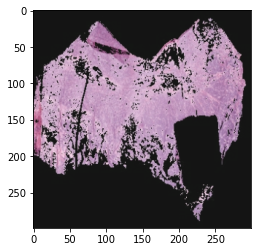

In [114]:
plt.imshow(img[31])

In [54]:
train_dataset = train_dataset.map(tf_scale_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [55]:
train_dataset = train_dataset.map(tf_filter_image,num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(1)

In [56]:
train_dataset = train_dataset.map(tf_tile,num_parallel_calls=tf.data.experimental.AUTOTUNE).cache()

In [57]:
train_dataset = train_dataset.flat_map(flat_map_impl).batch(10)

In [58]:
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)

In [140]:
import tensorflow_hub as hub
module = hub.KerasLayer("https://tfhub.dev/google/efficientnet/b7/classification/1")

KeyboardInterrupt: 

In [124]:
from tensorflow import keras
model = tf.keras.applications.InceptionV3(
 include_top=False, weights=None, input_shape=(299,299,3)
)

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc')
]
x = model.output
x = keras.layers.GlobalAveragePooling2D()(x)                 
predictions = keras.layers.Dense(5,activation='softmax')(x) 
model = keras.models.Model(inputs=model.input, outputs=predictions)
model.compile(optimizer='adam', loss = 'categorical_crossentropy',metrics=METRICS)

In [125]:
tb = tf.keras.callbacks.TensorBoard()

In [126]:
es = tf.keras.callbacks.EarlyStopping(patience=5)

In [127]:
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d_94 (Conv2D)              (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_94 (BatchNo (None, 149, 149, 32) 96          conv2d_94[0][0]                  
__________________________________________________________________________________________________
activation_94 (Activation)      (None, 149, 149, 32) 0           batch_normalization_94[0][0]     
_______________________________________________________________________________________

Total params: 21,813,029
Trainable params: 21,778,597
Non-trainable params: 34,432
__________________________________________________________________________________________________


In [128]:
model.fit(train_dataset,epochs=50,validation_data=valid_dataset,callbacks=[tb,es])

Epoch 1/50
35/35 [==============================] - 25s 719ms/step - loss: 0.6429 - tp: 895.0000 - fp: 144.0000 - tn: 4284.0000 - fn: 212.0000 - accuracy: 0.9357 - precision: 0.8614 - recall: 0.8085 - auc: 0.9538 - val_loss: 1.0352 - val_tp: 5.0000 - val_fp: 35.0000 - val_tn: 513.0000 - val_fn: 132.0000 - val_accuracy: 0.7562 - val_precision: 0.1250 - val_recall: 0.0365 - val_auc: 0.7695
Epoch 2/50
35/35 [==============================] - 23s 652ms/step - loss: 0.3787 - tp: 957.0000 - fp: 150.0000 - tn: 4278.0000 - fn: 150.0000 - accuracy: 0.9458 - precision: 0.8645 - recall: 0.8645 - auc: 0.9774 - val_loss: 0.5616 - val_tp: 124.0000 - val_fp: 13.0000 - val_tn: 535.0000 - val_fn: 13.0000 - val_accuracy: 0.9620 - val_precision: 0.9051 - val_recall: 0.9051 - val_auc: 0.9713
Epoch 3/50
35/35 [==============================] - 23s 654ms/step - loss: 0.3633 - tp: 976.0000 - fp: 129.0000 - tn: 4299.0000 - fn: 131.0000 - accuracy: 0.9530 - precision: 0.8833 - recall: 0.8817 - auc: 0.9787 - va

In [131]:
result = model.evaluate(test_dataset)

124/124 [==============================] - 3s 23ms/step - loss: 0.5597 - tp: 103.0000 - fp: 21.0000 - tn: 475.0000 - fn: 21.0000 - accuracy: 0.9323 - precision: 0.8306 - recall: 0.8306 - auc: 0.9434


In [17]:
%load_ext tensorboard
%tensorboard --logdir logs
